# Classificador de Avaliações de Produto

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import pandas as pd

# Carrega o arquivo CSV em um DataFrame do pandas
df = pd.read_csv("/content/drive/MyDrive/COLAB'S/TESTES/Reviews.csv")

# Exibe o df
print(df.head())

#Selecionando o produto com mais avaliações
df= df[:20000]

#Seleciona as colunas do comentário completo edo rating
df = df[['Text', 'Score']]
# Detalha os dados
print(df.describe(include='all'))

print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

#Limpeza do Texto

In [3]:
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

# Faz o download das stopwords
nltk.download("stopwords")
stop_words = stopwords.words("english")

# Pré-processa o texto removendo os stopwords
def preprocess_text(text):
    text = text.lower()
    text = "".join([char for char in text if char.isalnum() or char.isspace()])
    tokens = [word for word in text.split() if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["Text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Distribuição das notas (Frequência)

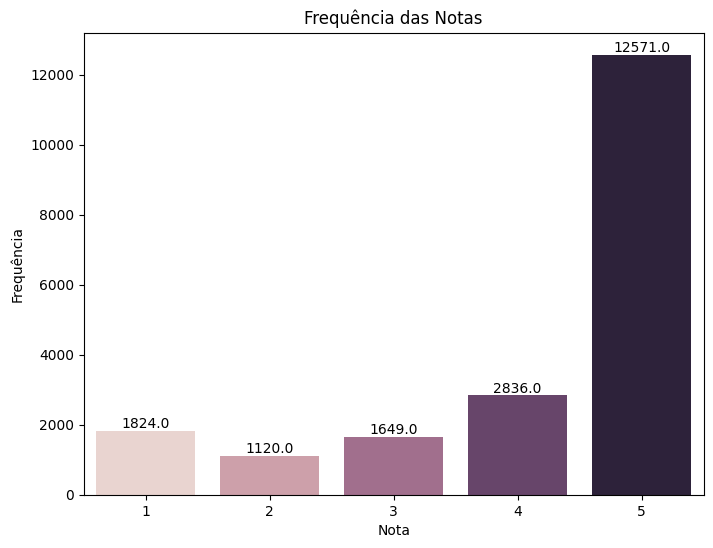

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

# Análise da Distribuição das Notas
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Score', data=df, hue='Score', legend=False)  # Changes here

# Adiciona os totais em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Frequência das Notas')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.show()

#SVM


*   Balanceamento pelo Score
*   Uso de Ngram para compreensão do contexto



In [20]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Divide o dataset stratificado pelo Score
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"], df["Score"], test_size=0.3, random_state=42,stratify=df["Score"])

# Pipeline para SVM com Bag of Words
pipeline_bow = Pipeline([
    ("vectorizer", TfidfVectorizer(ngram_range=(1, 3))),
    ("classifier", SVC())
])

# Treinamento
pipeline_bow.fit(X_train, y_train)
y_pred_bow = pipeline_bow.predict(X_test)

In [21]:
# Avaliação
print("SVM + Bag of Words")
print(classification_report(y_test, y_pred_bow))

# Calcula a acurácia e F1 score
accuracy_bow = accuracy_score(y_test, y_pred_bow)
f1_bow = f1_score(y_test, y_pred_bow, average='weighted')

print(f"Accuracy: {accuracy_bow}")
print(f"F1-score: {f1_bow}")

SVM + Bag of Words
              precision    recall  f1-score   support

           1       0.93      0.11      0.20       547
           2       1.00      0.06      0.12       336
           3       0.94      0.07      0.13       495
           4       0.60      0.08      0.14       851
           5       0.65      1.00      0.79      3771

    accuracy                           0.66      6000
   macro avg       0.83      0.26      0.28      6000
weighted avg       0.71      0.66      0.55      6000

Accuracy: 0.6573333333333333
F1-score: 0.5509503211619117


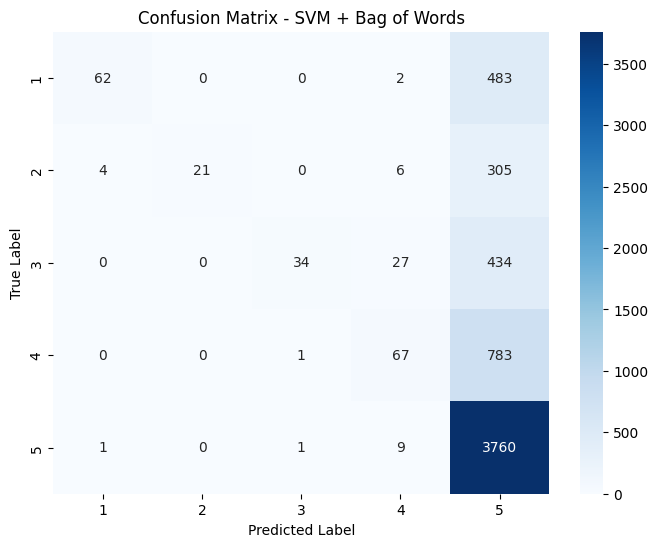

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to create a confusion matrix heatmap
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot the confusion matrix for the BoW model
plot_confusion_matrix(y_test, y_pred_bow, title="Confusion Matrix - SVM + Bag of Words")

#SVM + EMbeddings

In [23]:
# Faz o Download do Modelo
!python -m spacy download en_core_web_md
import spacy
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Usa embeddings do spaCy
nlp = spacy.load("en_core_web_md")
X_train_embedded = [nlp(text).vector for text in X_train]
X_test_embedded = [nlp(text).vector for text in X_test]

# Normaliza os embeddings
scaler = StandardScaler()
X_train_embedded = scaler.fit_transform(X_train_embedded)
X_test_embedded = scaler.transform(X_test_embedded)

# Treina o SVM com embeddings
svm_embedding = SVC()
svm_embedding.fit(X_train_embedded, y_train)
y_pred_embed = svm_embedding.predict(X_test_embedded)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 38.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [24]:
# Avaliação
print("SVM + Embeddings")
print(classification_report(y_test, y_pred_embed))

# Calcula a acurácia e F1 score
accuracy_embed = accuracy_score(y_test, y_pred_embed)
f1_embed = f1_score(y_test, y_pred_embed, average='weighted')

print(f"Accuracy: {accuracy_embed}")
print(f"F1-score: {f1_embed}")

SVM + Embeddings
              precision    recall  f1-score   support

           1       0.62      0.42      0.50       547
           2       0.58      0.03      0.06       336
           3       0.46      0.06      0.11       495
           4       0.46      0.04      0.07       851
           5       0.68      0.99      0.81      3771

    accuracy                           0.67      6000
   macro avg       0.56      0.31      0.31      6000
weighted avg       0.62      0.67      0.57      6000

Accuracy: 0.6708333333333333
F1-score: 0.5742840750572394


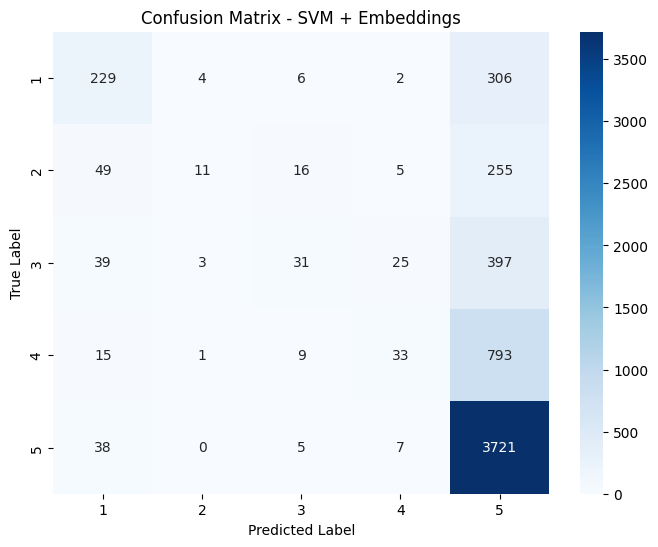

In [25]:
# Plot the confusion matrix para
plot_confusion_matrix(y_test, y_pred_embed, title="Confusion Matrix - SVM + Embeddings")

## BERT

In [13]:
from transformers import DistilBertTokenizer, BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay, TFDistilBertForSequenceClassification
import tensorflow as tf

# BERT
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Tokenização os dados
X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="tf")
X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="tf")

# Define o otimizador e a função de perda
optimizer = AdamWeightDecay(learning_rate=3e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

# Loop de treinamento personalizado
def train_step(inputs, targets):
    targets = targets - 1
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = loss_fn(targets, predictions.logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    metrics.update_state(targets, predictions.logits)
    return loss, metrics.result()

# Treinamento com Batchs
epochs = 10
batch_size = 40
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(0, len(X_train), batch_size):
        batch_inputs = {k: v[i:i + batch_size] for k, v in X_train_tokens.data.items()}
        batch_targets = y_train[i:i + batch_size]
        # Subtraindo 1 dos targets para ajustar o intervalo para 0-4
        loss, accuracy = train_step(batch_inputs, batch_targets)
        print(f"Batch {i // batch_size + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")


Epoch 1/10
Batch 1: Loss = 1.5996, Accuracy = 0.2250
Batch 2: Loss = 1.5361, Accuracy = 0.4500
Batch 3: Loss = 1.5071, Accuracy = 0.5000
Batch 4: Loss = 1.4511, Accuracy = 0.5500
Batch 5: Loss = 1.3830, Accuracy = 0.5800
Batch 6: Loss = 1.3190, Accuracy = 0.6042
Batch 7: Loss = 1.3060, Accuracy = 0.6143
Batch 8: Loss = 1.2639, Accuracy = 0.6187
Batch 9: Loss = 1.2253, Accuracy = 0.6222
Batch 10: Loss = 1.3032, Accuracy = 0.6175
Batch 11: Loss = 1.1682, Accuracy = 0.6205
Batch 12: Loss = 1.1890, Accuracy = 0.6208
Batch 13: Loss = 1.2506, Accuracy = 0.6173
Batch 14: Loss = 1.1890, Accuracy = 0.6161
Batch 15: Loss = 1.1238, Accuracy = 0.6183
Batch 16: Loss = 1.4365, Accuracy = 0.6109
Batch 17: Loss = 1.1682, Accuracy = 0.6118
Batch 18: Loss = 1.2455, Accuracy = 0.6083
Batch 19: Loss = 0.9735, Accuracy = 0.6132
Batch 20: Loss = 1.2666, Accuracy = 0.6100
Batch 21: Loss = 1.2936, Accuracy = 0.6060
Batch 22: Loss = 1.0747, Accuracy = 0.6102
Batch 23: Loss = 0.9886, Accuracy = 0.6141
Batch 24:

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

batch_size = 40
logits_list = []

for i in tqdm(range(0, len(X_test_tokens["input_ids"]), batch_size)):
    batch_inputs = {k: v[i:i + batch_size] for k, v in X_test_tokens.items()}
    predictions = model(batch_inputs).logits
    logits_list.append(predictions)

# Concatenar todas as previsões
final_logits = tf.concat(logits_list, axis=0)

# Obtém os rótulos previstos a partir dos logits
predicted_labels = tf.argmax(final_logits, axis=1).numpy()

# Converte y_test para NumPy e diminui 1 para ajustar
y_test_adjusted = y_test.to_numpy() - 1  # Certifique-se de que y_test seja uma Pandas Series

# Calcula as métricas
accuracy_bert = accuracy_score(y_test_adjusted, predicted_labels)
f1_bert = f1_score(y_test_adjusted, predicted_labels, average="weighted")

# Calcula a perda média no conjunto de teste
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
average_loss = loss_fn(y_test_adjusted, final_logits).numpy()

# Resultados
print("\nResultados BERT:")
print(f"Perda no teste (Loss): {average_loss:.4f}")
print(f"Acurácia: {accuracy_bert:.4f}")
print(f"F1 Score (ponderado): {f1_bert:.4f}")

100%|██████████| 150/150 [00:15<00:00,  9.76it/s]


Resultados BERT:
Perda no teste (Loss): 1.6080
Acurácia: 0.6932
F1 Score (ponderado): 0.6869


# Matriz de confusão BERT

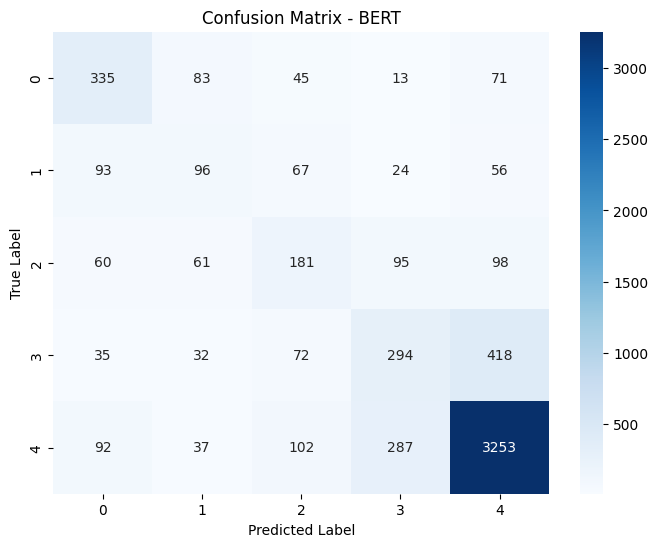

In [19]:
# ### Matriz de Confusão para o Resultado do BERT
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot the confusion matrix for the BERT model
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_test_adjusted, predicted_labels, title="Confusion Matrix - BERT")

#Comparação do desempenho dos modelos

In [26]:
# Cria um dicionário com os resultados
resultados = {
    "Modelo": ["SVM + Bag of Words", "SVM + Embeddings", "BERT"],
    "Acurácia": [accuracy_bow, accuracy_embed, accuracy_bert],
    "F1-Score": [f1_bow, f1_embed, f1_bert]
}

# Cria um DataFrame pandas com os resultados
df_resultados = pd.DataFrame(resultados)

# Exibe o DataFrame
print(df_resultados)

               Modelo  Acurácia  F1-Score
0  SVM + Bag of Words  0.657333  0.550950
1    SVM + Embeddings  0.670833  0.574284
2                BERT  0.693167  0.686931


<Figure size 1000x600 with 0 Axes>

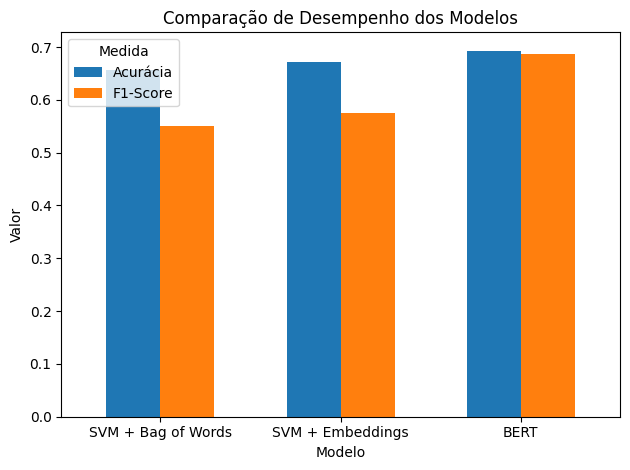

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
df_resultados.plot(x="Modelo", y=["Acurácia", "F1-Score"], kind="bar", width=0.6)
plt.title("Comparação de Desempenho dos Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.legend(title="Medida")
plt.tight_layout()
plt.show()